# Processing of AOML glider data for source water analysis

The contents of this notebook will perform the following:<br>
1) Extract just the transects by subsetting by time. This was PAINFUL but I couldn't think of a better way to do this. I loaded every dataset (34 total) and created a dictionary of transect start and end times and then saved the dictionary as a .pkl file. <br>
2) 

## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob
import pickle
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cpf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seawater as sw
import cmocean.cm as cmo
from scipy import integrate
from scipy.interpolate import griddata

sys.path.insert(0,'/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/analysis')
from analysis import gsw_rho, profile_mld, dist_from_lat_lon

## because pandas is stupid
class ChainedAssignent:
    def __init__(self, chained=None):
        acceptable = [None, 'warn', 'raise']
        assert chained in acceptable, "chained must be in " + str(acceptable)
        self.swcw = chained

    def __enter__(self):
        self.saved_swcw = pd.options.mode.chained_assignment
        pd.options.mode.chained_assignment = self.swcw
        return self

    def __exit__(self, *args):
        pd.options.mode.chained_assignment = self.saved_swcw

## Wrote this functin for calculating geostrophic velocity

In [218]:
def transect_df_to_transport_ds(df, lat_grid_dy=0.05, geo_dz=2):
    ## first drop where lon/lat are nan
    df = df[df['latitude'].notna()]

    ## find min and max latitude for lat grid
    min_lat = df.latitude.values.min()
    max_lat = df.latitude.values.max()
    ## make latitude grid
    lat_gridt = np.arange(min_lat, max_lat, lat_grid_dy) 
    ## take the mean longitude for calculating the grid distance
    mean_lon = np.nanmean(df.longitude.values)

    ## this is the grid dy in meters then (keep checking if 0.05 degree latitude grid sizing is ~5.5 km)
    dy = dist_from_lat_lon(lat_gridt[0],mean_lon,lat_gridt[1],mean_lon)

    ## Now make the vertical (depth) grid
    geo_dz = 2 # meters
    ## for the depth grid just go to the max depth rounded to the nearest geo_dz'th place (i.e. geo_dz = 2, round to 911 m to 912)
    max_depth = round(df.ctd_pressure.max()/2)*2
    depth_gridt = np.arange(0,max_depth,geo_dz)

    ## now turn the temporary 1D grids into a 2D grid
    lat_grid, depth_grid = np.meshgrid(lat_gridt,depth_gridt)

    ## do the interpolation
    griddensity     = griddata((df.latitude.values,df.ctd_pressure.values), df.density.values, (lat_grid, depth_grid), method='linear')
    ## also do it for t,s,O2 because that's what the analysis will eventually focus on
    gridtemperature = griddata((df.latitude.values,df.ctd_pressure.values), df.temperature.values, (lat_grid, depth_grid), method='linear')
    gridsalinity    = griddata((df.latitude.values,df.ctd_pressure.values), df.salinity.values, (lat_grid, depth_grid), method='linear')
    gridoxygen      = griddata((df.latitude.values,df.ctd_pressure.values), df.aanderaa4831_dissolved_oxygen_shifted, (lat_grid, depth_grid), method='linear')

    ## now get the depth averaged current on this latitude grid
    grid_du = np.empty(len(lat_gridt))
    grid_du[:] = np.nan
    ## also do this for the mean oxygen time shift, not as meaningful but still want to keep track of it
    mean_time_shift = np.empty(len(lat_gridt))
    mean_time_shift[:] = np.nan

    ## Loop to compile DAC in each latitude bin and take mean
    for x in np.arange(0,len(lat_gridt)-1):
        subset_df = df[(df.latitude >= lat_gridt[x]) & (df.latitude <= lat_gridt[x+1])]
        ## Do a quick DAC QAQC, set DAC greater than 10 m/s to nan
        subset_df.du[np.abs(subset_df.du) > 5] = np.nan
        ## take mean DAC in that latitude bin
        grid_du[x] = np.nanmean(subset_df.du.values)
        ## take mean oxygen time shift in that latitude bin
        mean_time_shift[x] = np.nanmean(subset_df.time_shift.values)

    ## Calculate d(rho)/d(y)
    d_rho_dy = np.gradient(griddensity,dy,axis=1)

    ## Calculate d(u)/d(z)
    CF = sw.extras.f(df.latitude.values.mean())
    g = sw.eos80.g(df.latitude.values.mean(), 0)
    therm_wind = (1/CF)*(g/1027)*d_rho_dy

    ## Now integrate d(u)/d(z) vertically to get u
    ## replace nan with zeros for integration
    therm_wind[np.where(np.isnan(therm_wind) ==True)] = 0
    ## flip to integrate from bottom and then flip back
    rel_Vg = integrate.cumtrapz(therm_wind[::-1,:], dx=geo_dz, initial=0, axis=0)[::-1,:]

    ## Now add the reference velocity
    vref = grid_du - np.nanmean(rel_Vg,axis=0)
    Vgeo = rel_Vg + vref

    ## Calculate mid-point time
    start_time = np.nanmin(pd.to_datetime(df.ctd_time[df['ctd_time'].notna()]))
    end_time   = np.nanmax(pd.to_datetime(df.ctd_time[df['ctd_time'].notna()]))
    dt = (end_time-start_time)/2
    mid_time = pd.to_datetime(df.ctd_time.values)[0]+dt

    ## Now save!
    geo_grid_ds = xr.Dataset(
        data_vars=dict(
            Vgeo =(["depth", "latitude"], Vgeo),
            density =(["depth", "latitude"], griddensity),
            temperature =(["depth", "latitude"], gridtemperature),
            salinity =(["depth", "latitude"], gridsalinity),
            oxygen =(["depth", "latitude"], gridoxygen),
            mean_time_shift = (["latitude"], mean_time_shift),
            mean_du = (["latitude"],grid_du)),
        coords=dict(
            depth = depth_gridt,
            latitude = lat_gridt,
            start_time = start_time,
            end_time = end_time,
            mid_time = mid_time
        ),
        attrs={'description': "Processed geostrophic velocity, temperature, salinity, density, and time shifted oxygen gridded/interpolated onto transect latitude and depth grid",
        # #'start_time': str(np.nanmin(df.ctd_time[df['ctd_time'].notna()])),
        # #'end_time': str(np.nanmax(df.ctd_time[df['ctd_time'].notna()])),
        # 'start_time': str(np.nanmin(pd.to_datetime(df.ctd_time))),
        # 'end_time': str(np.nanmax(pd.to_datetime(df.ctd_time))),
        # 'mid_time': str(mid_time),
        'deployment_name': df.deployment_name.values[0],
        'transect_number': df.transect_number.values[0],
        'mean_lon': mean_lon,
        'geo_dz': geo_dz,
        'dy': dy}
    )

    return geo_grid_ds




## Load data for subsetting transects

In [3]:
# x=1
# deployments = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed/*/', recursive=True))
# deployment_files = glob.glob(''.join([deployments[x],"*.csv"]))
# deploy_df = pd.concat((pd.read_csv(f) for f in deployment_files), ignore_index=True)
# deploy_df.set_index('ctd_time', inplace=True)
# print(deployments[x])
# print(deploy_df.index.min())
# print(deploy_df.index.max())

In [4]:
# ## For one range
# mask = (((deploy_df.index >= '2022-07-02') & (deploy_df.index <= '2022-07-18')))

# ## For more than one range
# # mask = (((deploy_df.index >= '2017-08-28') & (deploy_df.index <= '2017-10-02'))
# #         | ((deploy_df.index >= '2015-08-26') & (deploy_df.index < '2015-04-14')))

# subset_df = deploy_df.loc[mask]


# ## Map extent
# lon1 = -72
# lon2 = -63
# lat1 = 15
# lat2 = 22

# fig = plt.figure(figsize=(30,15))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ax.set_extent([lon1, lon2, lat1, lat2])
# LAND = cfeature.NaturalEarthFeature(
#     'physical', 'land', '10m',
#     edgecolor='black',
#     facecolor='tan'
# )
# ax.add_feature(LAND, zorder=0)

# plt.plot(subset_df.longitude.values,subset_df.latitude.values,'.',markersize=1)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.5, linestyle='--')
# gl.ylocator = mticker.FixedLocator([15.25, 15.5, 15.75, 16, 16.25, 16.5, 16.75, 17, 17.25, 17.5, 17.75, 18, 18.25, 18.5, 18.75, 19, 19.25, 19.5, 19.75, 20, 20.25, 20.5, 20.75, 21, 21.25, 21.5, 21.75])


## Create Dictionary

In [5]:
# subset_dict = {'SG609-M02FEB2015': {'start1': '2015-02-09', 'end1': '2015-02-21', 'start2': '2015-02-27', 'end2': '2015-04-13'},
#                 'SG609-M03JUL2015': {'start1': '2015-07-19', 'end1': '2015-08-11', 'start2': '2015-09-23', 'end2': '2015-10-02'},
#                 'SG609-M04MAR2016': {'start1': '2016-03-19', 'end1': '2016-04-01', 'start2': '2016-04-09', 'end2': '2016-04-24'},
#                 'SG609-M05JUL2016': {'start1': '2016-08-02', 'end1': '2016-08-12', 'start2': '2016-08-12', 'end2': '2016-08-28', 'start3': '2016-08-28', 'end3': '2016-09-06', 'start4': '2016-09-06', 'end4': '2016-09-29'},
#                 'SG610-M02FEB2015': {'start1': '2015-02-14', 'end1': '2015-02-25', 'start2': '2015-03-02', 'end2': '2015-04-14'},
#                 'SG610-M03JUL2015': {'start1': '2015-08-11', 'end1': '2015-08-21', 'start2': '2015-09-05', 'end2': '2015-09-17', 'start3': '2015-09-22', 'end3': '2015-10-02', 'start4': '2015-10-08', 'end4': '2015-10-20', 'start5': '2015-10-21', 'end5': '2015-11-18'},
#                 'SG610-M07JUL2017': {'start1': '2017-07-21', 'end1': '2017-08-05', 'start2': '2017-08-05', 'end2': '2017-08-28'},
#                 'SG610-M08JUL2018': {'start1': '2018-07-20', 'end1': '2018-08-11', 'start2': '2018-08-13', 'end2': '2018-08-25', 'start3': '2018-08-25', 'end3': '2018-09-09', 'start4': '2018-09-09', 'end4': '2018-09-31'},
#                 'SG610-M10JUL2020': {'start1': '2020-07-24', 'end1': '2020-08-17', 'start2': '2020-08-17', 'end2': '2020-08-30', 'start3': '2020-08-30', 'end3': '2020-09-18', 'start4': '2020-09-18', 'end4': '2020-10-02'},
#                 'SG610-M12JUL2022': {'start1': '2022-06-27', 'end1': '2022-07-14'},
#                 'SG630-M08JUL2018': {'start1': '2018-08-02', 'end1': '2018-08-14', 'start2': '2018-08-14', 'end2': '2018-08-20', 'start3': '2018-08-20', 'end3': '2018-08-29', 'start4': '2018-09-19', 'end4': '2018-09-31'},
#                 'SG630-M10JUL2020': {'start1': '2020-08-22', 'end1': '2020-09-03', 'start2': '2020-09-03', 'end2': '2020-09-25'},
#                 'SG635-M08JUL2018': {'start1': '2018-07-25', 'end1': '2018-08-04', 'start2': '2018-08-04', 'end2': '2018-08-20', 'start3': '2018-08-20', 'end3': '2018-09-01', 'start4': '2018-09-01', 'end4': '2018-09-09'},
#                 'SG635-M10JUL2020': {'start1': '2020-07-22', 'end1': '2020-08-22', 'start2': '2020-08-22', 'end2': '2020-09-13', 'start3': '2020-09-13', 'end3': '2020-09-29', 'start4': '2020-09-29', 'end4': '2020-10-13'},
#                 'SG635-M12JUL2022': {'start1': '2022-06-23', 'end1': '2022-07-05', 'start2': '2022-07-05', 'end2': '2022-07-18'},
#                 'SG649-M08JUL2018': {'start1': '2018-08-07', 'end1': '2018-08-31'},
#                 'SG649-M10JUL2020': {'start1': '2020-07-15', 'end1': '2020-08-15', 'start2': '2020-08-15', 'end2': '2020-09-03', 'start3': '2020-09-03', 'end3': '2020-09-19', 'start4': '2020-09-19', 'end4': '2020-10-05'},
#                 'SG649-M11JUL2021': {'start1': '2021-06-22', 'end1': '2021-07-22', 'start2': '2021-07-22', 'end2': '2021-08-18', 'start3': '2021-08-18', 'end3': '2021-09-16', 'start4': '2021-09-16', 'end4': '2021-10-08'},
#                 'SG663-M09JUL2019': {'start1': '2019-07-24', 'end1': '2019-08-09', 'start2': '2019-08-09', 'end2': '2019-08-20', 'start3': '2019-09-07', 'end3': '2019-09-15', 'start4': '2019-09-30', 'end4': '2019-10-12'},
#                 'SG663-M10JUL2020': {'start1': '2020-07-21', 'end1': '2020-08-10', 'start2': '2020-08-15', 'end2': '2020-08-27', 'start3': '2020-09-02', 'end3': '2020-09-16', 'start4': '2020-09-21', 'end4': '2020-10-04'},
#                 'SG663-M11JUL2021': {'start1': '2021-06-20', 'end1': '2021-06-30', 'start2': '2021-07-01', 'end2': '2021-07-17', 'start3': '2021-07-18', 'end3': '2021-08-06', 'start4': '2021-08-06', 'end4': '2021-08-18', 'start5': '2021-08-18', 'end5': '2021-09-06', 'start6': '2021-09-06', 'end6': '2021-09-28', 'start7': '2021-09-29', 'end7': '2021-10-05'},
#                 'SG664-M09JUL2019': {'start1': '2019-07-28', 'end1': '2019-08-15', 'start2': '2019-09-07', 'end2': '2019-09-30', 'start3': '2019-09-30', 'end3': '2019-10-11', 'start4': '2019-10-11', 'end4': '2019-10-25'},
#                 'SG664-M10JUL2020': {'start1': '2020-07-22', 'end1': '2020-08-11', 'start2': '2020-08-11', 'end2': '2020-08-27', 'start3': '2020-08-27', 'end3': '2020-09-16', 'start4': '2020-09-16', 'end4': '2020-09-30'},
#                 'SG665-M09JUL2019': {'start1': '2019-07-18', 'end1': '2019-08-11', 'start2': '2019-08-11', 'end2': '2019-08-27', 'start3': '2019-09-07', 'end3': '2019-09-16', 'start4': '2019-09-17', 'end4': '2019-10-08', 'start5': '2019-10-08', 'end5': '2019-11-03'},
#                 'SG665-M10JUL2020': {'start1': '2020-07-21', 'end1': '2020-08-13', 'start2': '2020-08-19', 'end2': '2020-09-11', 'start3': '2020-09-11', 'end3': '2020-09-27', 'start4': '2020-09-27', 'end4': '2020-10-16'},
#                 'SG666-M09JUL2019': {'start1': '2019-07-25', 'end1': '2019-08-15', 'start2': '2019-08-15', 'end2': '2019-08-27', 'start3': '2019-09-16', 'end3': '2019-10-08', 'start4': '2019-10-08', 'end4': '2019-10-20'},
#                 'SG667-M09JUL2019': {'start1': '2019-09-06', 'end1': '2019-10-02', 'start2': '2019-10-08', 'end2': '2019-10-29'},
#                 'SG667-M11JUL2021': {'start1': '2021-07-24', 'end1': '2021-08-05', 'start2': '2021-08-05', 'end2': '2021-08-23', 'start3': '2021-08-23', 'end3': '2021-09-12', 'start4': '2021-09-12', 'end4': '2021-09-28'},
#                 'SG667-M12JUL2022': {'start1': '2022-07-08', 'end1': '2022-07-18'},
#                 'SG668-M09JUL2019': {'start1': '2019-09-12', 'end1': '2019-09-19', 'start2': '2019-09-30', 'end2': '2019-10-09'},
#                 'SG668-M11JUL2021': {'start1': '2021-06-24', 'end1': '2021-07-10', 'start2': '2021-07-10', 'end2': '2021-07-21', 'start3': '2021-07-21', 'end3': '2021-07-30', 'start4': '2021-07-30', 'end4': '2021-08-13', 'start5': '2021-08-13', 'end5': '2021-08-24', 'start6': '2021-08-24', 'end6': '2021-09-04', 'start7': '2021-09-04', 'end7': '2021-09-19', 'start8': '2021-09-19', 'end8': '2021-09-29'},
#                 'SG669-M11JUL2021': {'start1': '2021-07-07', 'end1': '2021-08-01', 'start2': '2021-08-01', 'end2': '2021-08-30', 'start3': '2021-08-30', 'end3': '2021-09-22', 'start4': '2021-09-22', 'end4': '2021-10-17'},
#                 'SG678-M11JUL2021': {'start1': '2021-06-28', 'end1': '2021-07-23', 'start2': '2021-07-23', 'end2': '2021-08-04', 'start3': '2021-08-04', 'end3': '2021-08-22', 'start4': '2021-08-22', 'end4': '2021-09-11', 'start5': '2021-09-11', 'end5': '2021-09-20', 'start6': '2021-09-20', 'end6': '2021-10-07'},
#                 'SG678-M12JUL2022': {'start1': '2022-07-02', 'end1': '2022-07-18'}
# }
# subset_dict

# #'': {'start1': '', 'end1': '', 'start2': '', 'end2': '', 'start3': '', 'end3': '', 'start4': '', 'end4': ''}

## Save Dictionary as a .pkl file

In [6]:
## Save
# with open('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/AOML_transects_dictionary.pkl', 'wb') as f:
#     pickle.dump(subset_dict, f)

# ## Load       
# with open('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/AOML_transects_dictionary.pkl', 'rb') as f:
#     subset_dict = pickle.load(f)

## Load all data

In [7]:
# ## path to processed data
# files = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed/*/*.csv', recursive=True)

# full_df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

# full_df.set_index('ctd_time', inplace=True)


## Make a map of full dataset

In [8]:
# ## Map extent
# lon1 = -72
# lon2 = -63
# lat1 = 15
# lat2 = 22

# fig = plt.figure(figsize=(10,20))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ax.set_extent([lon1, lon2, lat1, lat2])
# LAND = cfeature.NaturalEarthFeature(
#     'physical', 'land', '10m',
#     edgecolor='black',
#     facecolor='tan'
# )
# ax.add_feature(LAND, zorder=0)

# plt.plot(full_df.longitude.values,full_df.latitude.values,'.')
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.5, linestyle='--')

## Load just the transects

In [9]:
# #x=3

# ## Loop through all of the deployments
# deployments = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed/*/', recursive=True))

# ## Initialize counter for creating transect_number variable in dataframes
# transect_number = int()

# for x in np.arange(0,len(deployments)):
#     ## Pull out all files from a deployment
#     deployment_files = glob.glob(''.join([deployments[x],"*.csv"]))
#     ## Load all files from a deployment
#     dft = pd.concat((pd.read_csv(f) for f in deployment_files), ignore_index=True)

#     ## Specific deployment name
#     fname = deployment_files[0][-25:-9]

#     ## Now loop through all of the subsetted transects in a deployment here
#     ## ONLY the even indicies because doing start and end
    
#     for y in np.arange(0,len(subset_dict[fname]),2):
#         ## Start at 1 because 0 is dumb, add one through each iteration of the loop
#         ## This is initialized outside of the main loop so its value is retained through the iterations
#         ## of this nested loop.
#         transect_number+=1

#         ## Need this because can't combine xarray ds is one doesn't exist, so after first, concat to existing ds
#         if y == 0:
#             ## Pull out start and end times
#             start_tm = list(subset_dict[fname].items())[y][1]
#             end_tm   = list(subset_dict[fname].items())[y+1][1]
#             ## Mask for data we want
#             mask = (((dft.ctd_time >= start_tm) & (dft.ctd_time <= end_tm)))
#             ## Subset to just that data
#             subset_df = dft.loc[mask]
#             ## Create transect # variable
#             subset_df['transect_number'] = transect_number
#             ## Create deployment name variable
#             subset_df['deployment_name'] = fname
#             ## Make the transect # the index
#             subset_df.set_index('transect_number', inplace=True)
#             ## Turn into an xarray dataset
#             subset_ds = subset_df.to_xarray()
        
#         ## Past first iteration, concat to existing ds
#         else:
#             ## Pull out start and end times
#             start_tm = list(subset_dict[fname].items())[y][1]
#             end_tm   = list(subset_dict[fname].items())[y+1][1]
#             ## Mask for data we want
#             mask = (((dft.ctd_time >= start_tm) & (dft.ctd_time <= end_tm)))
#             ## Subset to just that data
#             subset_df2 = dft.loc[mask]
#             ## Create transect # variable
#             subset_df2['transect_number'] = transect_number
#             ## Create deployment name variable
#             subset_df2['deployment_name'] = fname
#             ## Make the transect # the index
#             subset_df2.set_index('transect_number', inplace=True)
#             ## Turn into an xarray dataset
#             subset_ds2 = subset_df2.to_xarray()
#             ## Concat to existing ds
#             subset_ds = xr.concat([subset_ds, subset_ds2], dim='transect_number')
    
#     ## Need this because can't combine xarray ds is one doesn't exist, so after first, concat to existing ds
#     if x ==0:
#         tot_transects_ds = subset_ds
#     ## Past first iteration, concat to existing ds
#     else:
#         tot_transects_ds = xr.concat([tot_transects_ds,subset_ds], dim='transect_number')
#     print('done deployment #',x, 'out of', len(deployments))


In [10]:
# ## Loop through all of the deployments
# deployments = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed/*/', recursive=True))

# ## Initialize dataframe
# tot_transects_df = []

# ## Initialize counter for creating transect_number variable in dataframes
# transect_number = int()

# for x in np.arange(0,len(deployments)):
#     ## Pull out all files from a deployment
#     deployment_files = glob.glob(''.join([deployments[x],"*.csv"]))
#     ## Load all files from a deployment
#     dft = pd.concat((pd.read_csv(f) for f in deployment_files), ignore_index=True)

#     ## Specific deployment name
#     fname = deployment_files[0][-25:-9]

#     ## Now loop through all of the subsetted transects in a deployment here
#     ## ONLY the even indicies because doing start and end
    
#     for y in np.arange(0,len(subset_dict[fname]),2):
#         ## Start at 1 because 0 is dumb, add one through each iteration of the loop
#         ## This is initialized outside of the main loop so its value is retained through the iterations
#         ## of this nested loop.
#         transect_number+=1

#         ## Pull out start and end times
#         start_tm = list(subset_dict[fname].items())[y][1]
#         end_tm   = list(subset_dict[fname].items())[y+1][1]
#         ## Mask for data we want
#         mask = (((dft.ctd_time >= start_tm) & (dft.ctd_time <= end_tm)))
#         ## Subset to just that data
#         subset_df = dft.loc[mask]
#         ## Create transect # variable
#         subset_df['transect_number'] = transect_number
#         ## Create deployment name variable
#         subset_df['deployment_name'] = fname
#         ## Make the transect # the index
#         subset_df.set_index('ctd_time', inplace=True)

#         if ((x==0) and (y==0)):
#             tot_transect_df = subset_df
#             print('done deployment #',x, 'out of', len(deployments))
#         else:
#             tot_transect_df = pd.concat([tot_transect_df,subset_df])
#             print('done deployment #',x, 'out of', len(deployments))


In [11]:
## Save data (this takes ~3 min)
# tot_transect_df.to_csv('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/AOML_data_subset_transects.csv')  

In [30]:
## Load total dataframe (this takes ~30 seconds)
tot_transect_df = pd.read_csv('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/AOML_data_subset_transects.csv')

In [31]:
tot_transect_df

,ctd_time,ctd_pressure,aanderaa4831_dissolved_oxygen_shifted,downs,longitude,latitude,temperature,salinity,density,aanderaa4831_dissolved_oxygen,du,dv,su,sv,time_shift,transect_number,deployment_name
0,2015-02-09 08:21:40,1.278298,192.300091,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,1,SG609-M02FEB2015
1,2015-02-09 08:21:49,1.321579,192.386667,1.0,-67.465350,17.555617,26.974641,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
2,2015-02-09 08:21:59,1.778545,192.418361,1.0,-67.465350,17.555612,26.975472,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
3,2015-02-09 08:22:18,3.029667,192.387976,1.0,-67.465349,17.555604,26.984981,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
4,2015-02-09 08:22:28,4.100253,192.504311,1.0,-67.465302,17.555602,26.994143,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10807892,2022-07-07 14:08:22,13.041327,241.704636,0.0,-65.033142,17.011794,28.242144,34.262031,1021.762859,241.776639,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022
10807893,2022-07-07 14:08:31,11.730388,241.883389,0.0,-65.033147,17.011787,28.254553,34.259990,1021.757259,241.690682,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022
10807894,2022-07-07 14:08:42,10.016299,242.055362,0.0,-65.033152,17.011778,28.258000,34.259422,1021.755703,241.742825,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022
10807895,2022-07-07 14:08:52,8.443124,241.966350,0.0,-65.033155,17.011770,28.257050,34.258350,1021.755209,241.782111,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022


In [43]:
# y=1
# mask = (tot_transect_df.transect_number == y)
# mid_df = tot_transect_df[mask]

# points2plot = 1000

# plt.figure(figsize=(7,10))
# plt.plot(mid_df.aanderaa4831_dissolved_oxygen[0:points2plot],mid_df.ctd_pressure[0:points2plot],label='uncorrected')
# plt.plot(mid_df.aanderaa4831_dissolved_oxygen_shifted[0:points2plot],mid_df.ctd_pressure[0:points2plot],label='corrected')
# plt.gca().invert_yaxis()
# plt.legend()


## Now loop through each transect, regrid/inerpolate, calculate geostrophic velocity, and resave dataframe as an xr dataset

In [220]:
## This takes ~7 minutes
tot_transects = len(np.unique(tot_transect_df.transect_number))

for y in np.arange(1,tot_transects+1):
    ## because pandas is stupid and I don't wan to deal with debugging the weird "copy of a slice" error
    with ChainedAssignent():
        ## subset to just the y transect number
        mask = (tot_transect_df.transect_number == y)
        mid_df = tot_transect_df[mask]
        ## Calculate geostrophic velocity
        geo_grid_ds = transect_df_to_transport_ds(mid_df)
        ## resave new dataframe
        save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/transect_number_'+str(geo_grid_ds.attrs['transect_number'])+'.nc'
        geo_grid_ds.to_netcdf(save_name)
        print('done:',y,'out of',tot_transects)

# y=1
# ## because pandas is stupid and I don't wan to deal with debugging the weird "copy of a slice" error
# with ChainedAssignent():
#     ## subset to just the y transect number
#     mask = (tot_transect_df.transect_number == y)
#     mid_df = tot_transect_df[mask]
#     ## Calculate geostrophic velocity
#     geo_grid_ds = transect_df_to_transport_ds(mid_df)
#     save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/transect_number_'+str(geo_grid_ds.attrs['transect_number'])+'.nc'
#     geo_grid_ds.to_netcdf(save_name)

# geo_grid_ds

done: 1 out of 117
done: 2 out of 117
done: 3 out of 117
done: 4 out of 117
done: 5 out of 117
done: 6 out of 117
done: 7 out of 117
done: 8 out of 117
done: 9 out of 117
done: 10 out of 117
done: 11 out of 117
done: 12 out of 117
done: 13 out of 117
done: 14 out of 117
done: 15 out of 117
done: 16 out of 117
done: 17 out of 117
done: 18 out of 117
done: 19 out of 117


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


done: 20 out of 117


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


done: 21 out of 117


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


done: 22 out of 117
done: 23 out of 117
done: 24 out of 117


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


done: 25 out of 117
done: 26 out of 117
done: 27 out of 117


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


done: 28 out of 117
done: 29 out of 117
done: 30 out of 117
done: 31 out of 117
done: 32 out of 117
done: 33 out of 117
done: 34 out of 117
done: 35 out of 117
done: 36 out of 117
done: 37 out of 117
done: 38 out of 117
done: 39 out of 117
done: 40 out of 117
done: 41 out of 117
done: 42 out of 117
done: 43 out of 117
done: 44 out of 117


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


done: 45 out of 117
done: 46 out of 117
done: 47 out of 117
done: 48 out of 117
done: 49 out of 117
done: 50 out of 117
done: 51 out of 117
done: 52 out of 117
done: 53 out of 117
done: 54 out of 117
done: 55 out of 117
done: 56 out of 117
done: 57 out of 117
done: 58 out of 117
done: 59 out of 117
done: 60 out of 117
done: 61 out of 117
done: 62 out of 117
done: 63 out of 117
done: 64 out of 117
done: 65 out of 117
done: 66 out of 117
done: 67 out of 117
done: 68 out of 117
done: 69 out of 117
done: 70 out of 117
done: 71 out of 117
done: 72 out of 117
done: 73 out of 117
done: 74 out of 117
done: 75 out of 117
done: 76 out of 117
done: 77 out of 117
done: 78 out of 117
done: 79 out of 117
done: 80 out of 117
done: 81 out of 117
done: 82 out of 117
done: 83 out of 117
done: 84 out of 117
done: 85 out of 117
done: 86 out of 117
done: 87 out of 117
done: 88 out of 117
done: 89 out of 117
done: 90 out of 117
done: 91 out of 117
done: 92 out of 117
done: 93 out of 117
done: 94 out of 117


In [44]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))
ds = xr.open_dataset(transport_files[0])


Text(0.5, 0, 'Latitude')

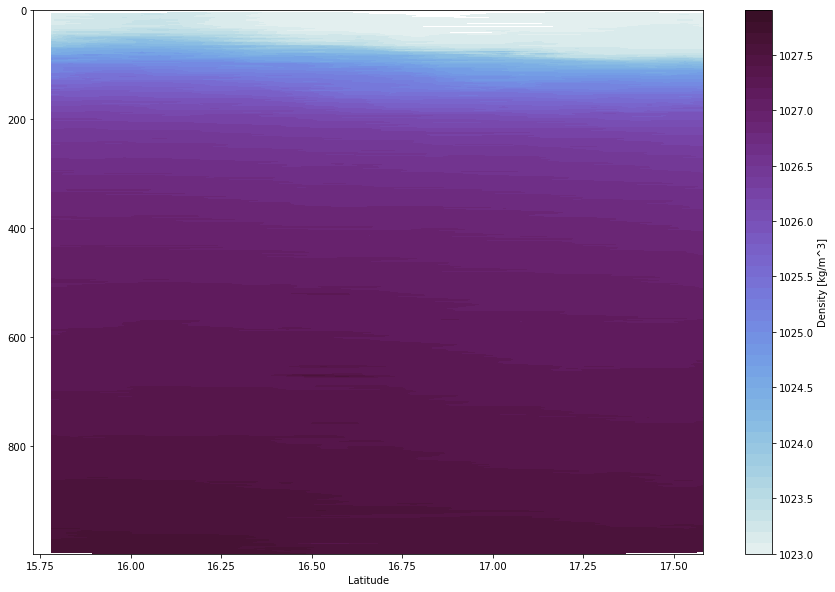

In [57]:
plt.figure(figsize=(15,10))
plt.contourf(ds.latitude,ds.depth,ds.density,cmap=cmo.dense,levels=np.arange(1023,1028,0.1))
plt.gca().invert_yaxis()
plt.colorbar(label='Density [kg/m^3]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

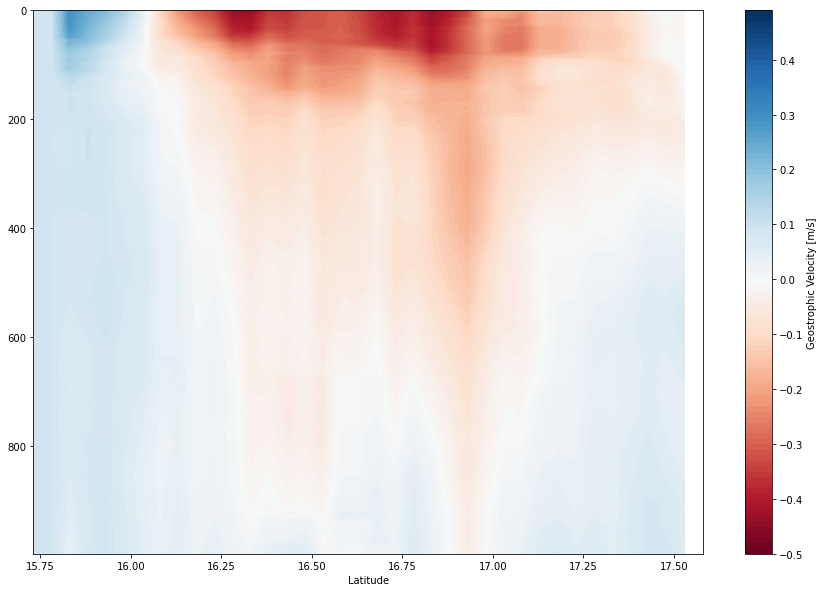

In [58]:
plt.figure(figsize=(15,10))
plt.contourf(ds.latitude,ds.depth,ds.Vgeo,cmap='RdBu',levels=np.arange(-0.5,0.5,0.01))
plt.gca().invert_yaxis()
plt.colorbar(label='Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

In [21]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

transport_north = np.empty(len(transport_files))
transport_north[:] = np.nan
transport_north_tm = np.empty(len(transport_files),dtype='datetime64[s]')

transport_south = np.empty(len(transport_files))
transport_south[:] = np.nan
transport_south_tm = np.empty(len(transport_files),dtype='datetime64[s]')


for x in np.arange(2,len(transport_files)):
    ds = xr.open_dataset(transport_files[x])
    if ds.latitude.mean() > 18.35:
        transport_north[x] = np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6)
        transport_north_tm[x] = ds.mid_time.values
        ds.close()
    else:
        transport_south[x] = np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6)
        transport_south_tm[x] = ds.mid_time.values
        ds.close()



In [28]:
np.nanmean(transport_south)

-5.0688637042459455

(-30.0, 30.0)

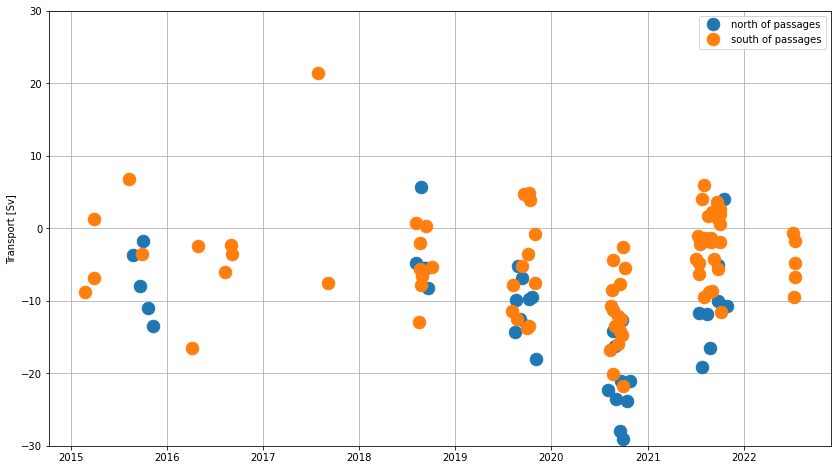

In [25]:
plt.figure(figsize=(14,8))
plt.plot(transport_north_tm,transport_north,'.',label='north of passages',markersize=25)
plt.plot(transport_south_tm,transport_south,'.',label='south of passages',markersize=25)
plt.legend()
plt.grid()
plt.ylabel('Transport [Sv]')
plt.ylim(-30,30)


In [ ]:
plt.figure(figsize=(15,10))
#plt.contourf(geo_grid_ds.latitude,geo_grid_ds.depth,geo_grid_ds.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.01))
plt.pcolormesh(geo_grid_ds.latitude,geo_grid_ds.depth,geo_grid_ds.density,cmap=cmo.dense,vmin=1022,vmax=1028)
plt.colorbar()
plt.gca().invert_yaxis()


In [ ]:
plt.figure(figsize=(15,10))
plt.contourf(geo_grid_ds.latitude,geo_grid_ds.depth,geo_grid_ds.Vgeo,cmap='RdBu',levels=np.arange(-0.5,0.5,0.01))
plt.colorbar(label='E-W Geostrophic Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()


In [ ]:
## Map extent
lon1 = -72
lon2 = -63
lat1 = 15
lat2 = 22

fig = plt.figure(figsize=(10,20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

plt.plot(df.longitude.values,df.latitude.values,'.',markersize=2)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')




In [ ]:
## Map extent
lon1 = -72
lon2 = -63
lat1 = 15
lat2 = 22

fig = plt.figure(figsize=(10,20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

plt.plot(tot_transects_ds.longitude.values,tot_transects_ds.latitude.values,'.',markersize=2)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.ylocator = mticker.FixedLocator([18.35])




## Look at data north and south of the passages

In [ ]:
#north_df = xr.where(tot_transects_ds.latitude > 18.35)]
#south_df = tot_transects_ds[dict(tot_transects_ds.latitude < 18.35)]

#da.sel(time=slice("2000-01-01", "2000-01-02"))

north_ind = tot_transects_ds.latitude.values>18.35
south_ind = tot_transects_ds.latitude.values<18.35


In [ ]:
plt.plot(tot_transects_ds.salinity[north_ind],tot_transects_ds.temperature[north_ind],'.',label='north')
plt.plot(tot_transects_ds.salinity[south_ind],tot_transects_ds.temperature[south_ind],'.',label='south')
plt.xlim(32,38)
plt.legend()

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(tot_transects_ds.aanderaa4831_dissolved_oxygen_shifted[south_ind],tot_transects_ds.temperature[south_ind],'.',label='south')
plt.plot(tot_transects_ds.aanderaa4831_dissolved_oxygen_shifted[north_ind],tot_transects_ds.temperature[north_ind],'.',label='north')

plt.xlim(60,260)
plt.legend()
plt.xlabel('Oxygen Concentration')
plt.ylabel('Temperature')

In [ ]:
# plt.figure(figsize=(20,10))
# plt.scatter(np.arange(0,len(deploy_df.index)),deploy_df.ctd_pressure,c=deploy_df.aanderaa4831_dissolved_oxygen_shifted)
# plt.colorbar()
# plt.gca().invert_yaxis()